# Regression and Other Stories: Chapter 5

In [42]:
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from bambi import Model
import arviz as az
from scipy import stats
import numpy as np

In [43]:
n_girls = stats.binom(400, .488).rvs(1)
print(n_girls)

[196]


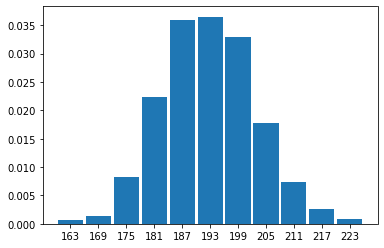

In [44]:
# With scipy.stats we do not need a loop to conduct 1000 simulations, but instead can specify it by changing the argument
# to rvs
n_sims = 1000
n_girls = stats.binom(400, .488).rvs(n_sims)
az.plot_dist(n_girls);

In [49]:
birth_types = pd.Series(["fraternal twin","identical twin","single birth"]) \
.sample(n=400,replace=True, weights=(1/125, 1/300, 1-1/125-1/300))

birth_types.value_counts()

single birth      394
fraternal twin      3
identical twin      3
dtype: int64

In [50]:
# For this smaller dataset we'll use pandas apply. For seriously large datasets consider ufuncs or other optimizations
# outside of the scope of this

def birthtype(birth_type):
    if birth_type == "single birth":
        counts = stats.binom(1, 0.488).rvs(1)
    elif birth_type == "identical twin":
        counts = 2*stats.binom(1, 0.495).rvs(1)
    elif birth_type == "fraternal twin":
        counts = stats.binom(2, 0.495).rvs(1)
    return counts.squeeze()

girls = birth_types.apply(birthtype)
girls.head()

2    0
2    1
2    1
2    0
2    0
dtype: int64

In [51]:
n_sims = 1000
n_girls = np.empty(n_sims)

for trial in range(n_sims):
    if trial % 100 == 0:
        print(trial)
    birth_types = pd.Series(["fraternal twin","identical twin","single birth"]) \
        .sample(n=400,replace=True, weights=(1/125, 1/300, 1-1/125-1/300))
    single_trial_num_girls = birth_types.apply(birthtype).sum()
    n_girls[trial] = single_trial_num_girls

0
100
200
300
400
500
600
700
800
900


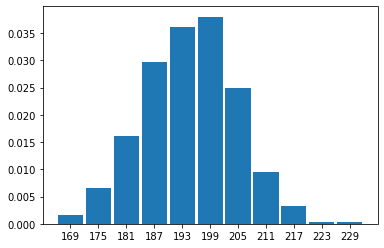

In [54]:
az.plot_dist(n_girls, kind="hist");

In [72]:
n_sims = 1000
y1 = stats.norm(3, .5).rvs(n_sims)
y2 = np.exp(y1)
y3 = stats.binom(20, .6).rvs(n_sims)
y4 = stats.poisson(5).rvs(n_sims)

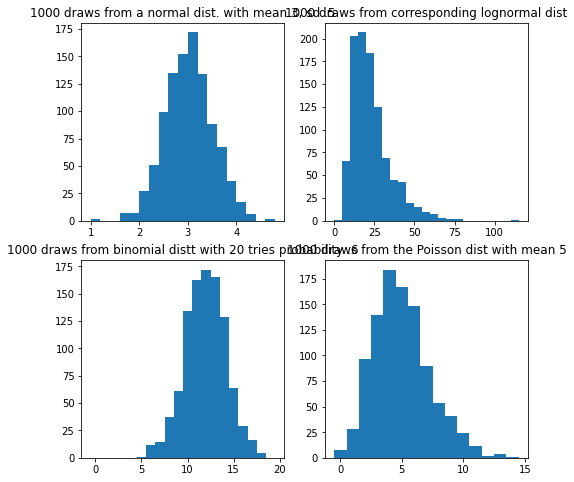

In [76]:
fig, axes = plt.subplots(2,2, figsize=(8,8))
axes[0][0].hist(y1, bins = np.arange(y1.min(), y1.max() + .2, .2))
axes[0][0].set_title("1000 draws from a normal dist. with mean 3, sd .5")

axes[0][1].hist(y2, bins = np.arange(0, y2.max() + 5, 5))
axes[0][1].set_title("1000 draws from corresponding lognormal dist")


axes[1][0].hist(y3, bins = np.arange(-.5, 20.5, 1))
axes[1][0].set_title("1000 draws from binomial distt with 20 tries probability .6")

axes[1][1].hist(y4, bins = np.arange(-.5, y4.max() + 1, 1))
axes[1][1].set_title("1000 draws from the Poisson dist with mean 5");

In [83]:
male = stats.binom(1, .48).rvs(1)
height = np.where(male ==1, stats.norm(69.1, 2.9).rvs(1), stats.norm(63.7, 2.7).rvs(1))

male, height

(array([0]), array([62.83140486]))

In [94]:
N = 10

male = stats.binom(1, .48).rvs(N)
height = np.where(male==1, stats.norm(69.1, 2.9).rvs(N), stats.norm(63.7, 2.7).rvs(N))
avg_height = height.mean()
avg_height

66.58115969106144

<bound method Axes.set_title of <matplotlib.axes._subplots.AxesSubplot object at 0x7feadcb761d0>>

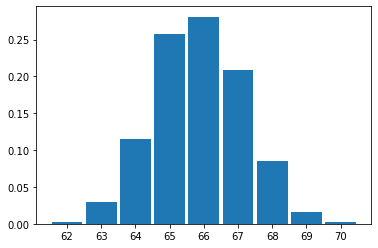

In [97]:
n_sims = 1000
avg_height = np.empty(n_sims)

for i in range(n_sims):
    N=10
    male = stats.binom(1, .48).rvs(N)
    height = np.where(male==1, stats.norm(69.1, 2.9).rvs(N), stats.norm(63.7, 2.7).rvs(N))
    avg_height[i] = height.mean()
    
ax = az.plot_dist(avg_height, kind="hist")
ax.set_title("Dist of average height of 10 adults")

In [129]:
def height_sim(n):
    male = stats.binom(1, .48).rvs(N)
    height = np.where(male==1, stats.norm(69.1, 2.9).rvs(N), stats.norm(63.7, 2.7).rvs(N))
    avg_height = height.mean()
    return avg_height

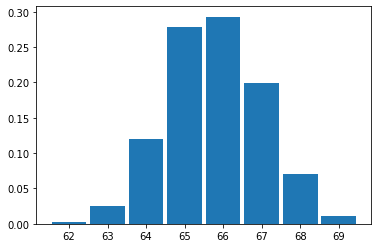

In [128]:
avg_height = np.array([height_sim(10) for _ in range(1000)])
az.plot_dist(avg_height, kind="hist")

In [111]:
z = stats.norm(5, 2).rvs(1000)
f"Mean= {z.mean()} Median = {np.median(z)} sd = {z.std()} mad sd = {stats.median_abs_deviation(z*1.483)}"

'Mean= 4.961517891773117 Median = 4.946479826139165 sd = 2.0151786041633093 mad sd = 2.065698072304722'

In [124]:
earnings = pd.read_csv("https://raw.githubusercontent.com/avehtari/ROS-Examples/master/Earnings/data/earnings.csv")
earn = earnings["earn"]

# We coerce this column to a bool to make filtering easier below
male = earnings["male"].astype(bool)

ratio = earn[~male].median() / earn[male].median()
ratio

0.6

In [133]:
# Well coerce once to make things easier
earnings["male"] = earnings["male"].astype(bool)

def boot_ratio(data):
    n_rows = data.shape[0]
    boot = earnings.sample(n_rows, replace=True)
    
    earn_boot = boot["earn"]
    male_boot = boot["male"]

    
    ratio = earn_boot[~male_boot].median() / earn_boot[male_boot].median()
    return ratio

In [ ]:
output = np.array([boot_ratio(earnings) for _ in range(10000)])
print(output.std())
az.plot_dist(output, kind="hist")
